## Imports

In [299]:
import os
import numpy as np
import torch
import albumentations as A
import torchvision.transforms.functional as TF
import torch.utils.checkpoint as cp
import cv2

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
from matplotlib import pyplot as plt

## Dataset

In [301]:
train_transform = A.Compose(
    [
        A.Resize(width=130, height=130),
        A.RandomCrop(width=128, height=128),
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.ColorJitter(p=0.5),
        ], p=1.0),
        A.Normalize(
            mean=[0, 0, 0],
            std=[1, 1, 1],
            max_pixel_value=255,
        ),
        ToTensorV2(),
    ]
)

In [302]:
val_transform = A.Compose(
        [
            A.Resize(width=130, height=130),
            A.CenterCrop(width=128, height=128),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

In [304]:
def process_mask(mask, colormap):
    output_mask = []
    mask = np.array(mask)

    for color in colormap:
        cmap = np.all(np.equal(mask, color), axis=-1)
        output_mask.append(cmap)

    output_mask = np.stack(output_mask, axis=-1)
    output_mask = torch.tensor(output_mask).float().permute(2, 0, 1)
    
    return output_mask

In [305]:
class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", ".png"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask = np.expand_dims(mask, axis=-1)

        if self.transform is not None:
            
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
            mask = process_mask(mask, color_map)      
    
        return image, mask

In [306]:
image_dir = 'data/images/'
mask_dir = 'data/annotations/trimaps/'

In [307]:
train_dataset = CarvanaDataset(image_dir, mask_dir, transform=train_transform)
valid_dataset = CarvanaDataset(image_dir, mask_dir, transform=val_transform)

In [308]:
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=8, shuffle=True)

In [309]:
sample = train_dataset[9]

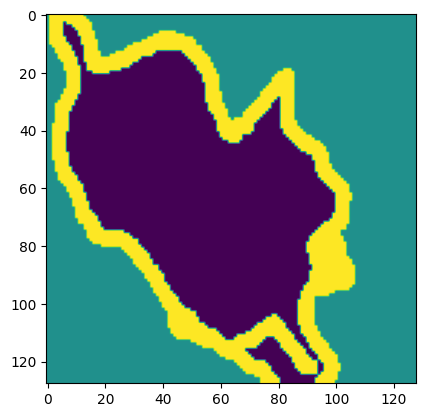

In [310]:

sample_mask = sample[1].permute(1, 2, 0)
sample_mask = np.array(sample_mask)

plt.imshow(np.argmax(sample_mask, axis=-1))

(128, 128, 3)

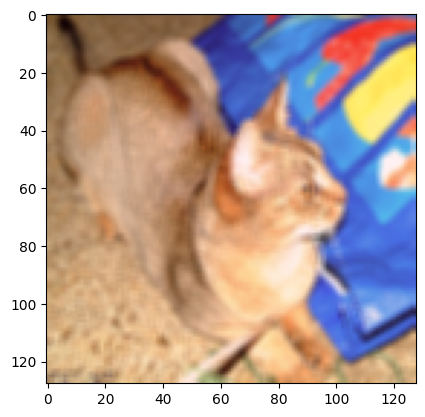

In [311]:
sample_image = sample[0].permute(1, 2, 0)
sample_image = np.array(sample_image)

plt.imshow(sample_image)

sample_image.shape

## Model

In [312]:
class DoubleConv(nn.Module):
        
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()

        self.duble_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
            
        )

    def forward(self, input):
        return self.duble_conv(input)

In [313]:
class U_NET(nn.Module):

    def __init__(self, in_channels, out_channels, features=[64, 128, 256, 512]):
        super().__init__()

        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels=in_channels, out_channels=feature))
            in_channels = feature
        
        for feature in reversed(features):

            self.ups.append(
                nn.ConvTranspose2d(in_channels=feature*2, out_channels=feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(in_channels=feature*2, out_channels=feature))
             
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

        
    def forward(self, x):

        skip_connections = []
        
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] #reverse

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]

            if x.shape != skip.shape:
                x = TF.resize(x, size=skip.shape[2:])

            concat_skip = torch.cat((skip, x), dim=1)
            x = self.ups[idx+1](concat_skip)
            

        return self.final_conv(x)

In [314]:
model = U_NET(3, 3)
model

U_NET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (duble_conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (duble_conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), str

In [315]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [316]:
model = model.to(device)

## Train

In [318]:
class_weight=torch.tensor([1, 1, 3]).to(device)
loss = nn.CrossEntropyLoss(weight=class_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [319]:
def cal_dice_IOU(y_pred, y, color_map):

    smooth = 1.0
    dice = 0.0
    IOU = 0.0

    y_pred = y_pred.argmax(dim=1)
    y = y.argmax(dim=1)

    for i in range(len(color_map)):
         
         intersection = torch.sum((y_pred == i) * (y==i))
         y_area = torch.sum((y == i))
         y_pred_area = torch.sum((y_pred == i))
         combined_area = y_pred_area + y_area

         IOU += (intersection +smooth) / (combined_area - intersection + smooth)
         

         dice += (2 * intersection +smooth) / (combined_area + smooth)
         

    return dice / len(color_map) , IOU / len(color_map)


In [320]:
def train(train_loader, valid_loader, model, epochs, optimizer, loss, device, metric_fn, color_map):

    for epoch in range(epochs):

        val_IOU = 0.0
        val_dice = 0.0

        model.train()

        for image, mask in train_loader:

            image = image.to(device)
            mask = mask.to(device)
            
            pred_mask = model(image)
            optimizer.zero_grad()
                       

            with torch.set_grad_enabled(True):
                mask_loss = loss(pred_mask, mask)
                mask_loss.backward()
                optimizer.step()
                
            torch.cuda.empty_cache()

        model.eval()

        for val_image, val_mask in valid_loader:
            val_image = val_image.to(device)
            val_mask = val_mask.to(device)

            pred_val_mask = model(val_image)

            val_dice += metric_fn(pred_val_mask, val_mask, color_map)[0]
            val_IOU += metric_fn(pred_val_mask, val_mask, color_map)[1]

            torch.cuda.empty_cache()

            

        print(f'epopch{epoch} vali_dice: {val_dice / len(valid_loader)} \n val_IOU: {val_IOU / len(valid_loader)}')
        



In [ ]:
color_map = [1, 2, 3]

In [321]:
train(train_loader, valid_loader, model, 15, optimizer, loss, device, cal_dice_IOU, color_map)

epopch0 vali_dice: 0.7095320224761963 
 val_IOU: 0.5696013569831848
epopch1 vali_dice: 0.7522088289260864 
 val_IOU: 0.6221875548362732
epopch2 vali_dice: 0.7771443724632263 
 val_IOU: 0.6557294130325317
epopch3 vali_dice: 0.7945091724395752 
 val_IOU: 0.6780964136123657
epopch4 vali_dice: 0.806144654750824 
 val_IOU: 0.6944014430046082
epopch5 vali_dice: 0.8078727722167969 
 val_IOU: 0.6965938210487366
epopch6 vali_dice: 0.823279619216919 
 val_IOU: 0.717693567276001
epopch7 vali_dice: 0.8109985589981079 
 val_IOU: 0.7011798620223999
epopch8 vali_dice: 0.8172008395195007 
 val_IOU: 0.7091731429100037
epopch9 vali_dice: 0.8308789730072021 
 val_IOU: 0.7279599905014038
epopch10 vali_dice: 0.8229213953018188 
 val_IOU: 0.7173365354537964
epopch11 vali_dice: 0.8387624025344849 
 val_IOU: 0.7392520904541016
epopch12 vali_dice: 0.8273833394050598 
 val_IOU: 0.7235212922096252
epopch13 vali_dice: 0.8257275223731995 
 val_IOU: 0.7206591963768005
epopch14 vali_dice: 0.8306499719619751 
 val_IO

In [322]:
path = 'saved_model_15_weights.pth'
torch.save(model, path)

## Test


In [323]:
torch.cuda.empty_cache()

In [324]:
loaded_model = U_NET(3, 3)
path = 'saved_model_15_weights.pth'
loded_model = torch.load(path)
loded_model.eval()

U_NET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (duble_conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (duble_conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), str

In [325]:
loded_model = loaded_model.to(device)

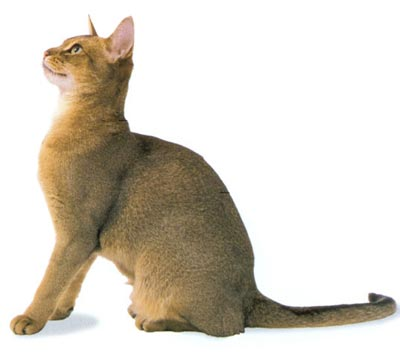

In [340]:
test_image = Image.open('data/images/Abyssinian_19.jpg')
test_image

In [ ]:
test_image = np.array(test_image.convert("RGB"))

augmentations = val_transform(image=test_image)

test_image = augmentations["image"]

test_image = torch.unsqueeze(test_image, dim=0).to(device)

In [342]:
test_image.shape

torch.Size([1, 3, 128, 128])

In [343]:
pred = loaded_model(test_image)

In [345]:
pred = torch.sigmoid(pred)
pred = pred.argmax(dim=1)

In [ ]:
pred = pred.cpu()
pred = pred.detach().numpy()
pred = pred.squeeze(0)

In [347]:
pred.shape

(128, 128)

In [348]:
pred = np.expand_dims(pred, axis=(2))
pred.shape

(128, 128, 1)

In [349]:
pred = np.float32(pred)
pred = cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB)

In [350]:
      
height, width = pred.shape[0:2]

for i in range(height)

    for j in range(width):
        
        if pred[i, j, 0] == 0 and pred[i, j, 1] == 0 and pred[i, j, 2] == 0:
           
            pred[i, j] = [255, 0, 0]
            
        elif pred[i, j, 0] == 1 and pred[i, j, 1] == 1 and pred[i, j, 2] == 1:
            
            pred[i, j] = [0, 255, 0]  

        else:
            
            pred[i, j] = [0, 0, 0] 
            

In [351]:
np.unique(pred)

array([  0., 255.], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


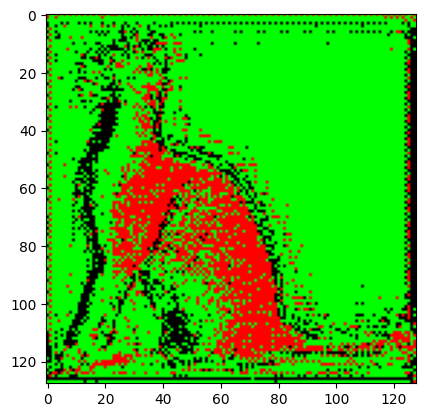

In [352]:
plt.imshow(pred)